<a href="https://colab.research.google.com/github/atanilson/Comp702/blob/main/Comp702_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries

In [ ]:
import torch
from torch import nn

# To get data
import requests
import zipfile
from pathlib import Path
import os

# Tranforming data
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
device

'cuda'

# Data exploration

## Downlaoding the data

In [ ]:
!wget https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1 -O EuroSAT_RGB.zip
!unzip -q EuroSAT_RGB.zip -d "data"
!rm EuroSAT_RGB.zip

--2025-07-02 08:23:17--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M  2.18MB/s    in 2m 0s   

2025-07-02 08:25:18 (767 KB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]



In [ ]:
data_path = Path("data/")
#data_path.mkdir(parents=True, exist_ok=True)
#!mv EuroSAT_RGB data/
EuroSAT_RGB_path = data_path/"EuroSAT_RGB"

In [ ]:
def inspect_datafolder(dir_dataset):
  """Walks though the dataset dir and return the content"""
  for dirpath, dirnames, filenames in os.walk(dir_dataset):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}.")

In [ ]:
inspect_datafolder(EuroSAT_RGB_path)

There are 10 folders and 0 images in data/EuroSAT_RGB.
There are 0 folders and 3000 images in data/EuroSAT_RGB/SeaLake.
There are 0 folders and 3000 images in data/EuroSAT_RGB/AnnualCrop.
There are 0 folders and 3000 images in data/EuroSAT_RGB/HerbaceousVegetation.
There are 0 folders and 2500 images in data/EuroSAT_RGB/Highway.
There are 0 folders and 2500 images in data/EuroSAT_RGB/River.
There are 0 folders and 3000 images in data/EuroSAT_RGB/Residential.
There are 0 folders and 2500 images in data/EuroSAT_RGB/Industrial.
There are 0 folders and 2500 images in data/EuroSAT_RGB/PermanentCrop.
There are 0 folders and 2000 images in data/EuroSAT_RGB/Pasture.
There are 0 folders and 3000 images in data/EuroSAT_RGB/Forest.


## Visualising

In [ ]:
import random
from PIL import Image

random.seed(42)

# Get the list of all possible paths in the dataset
image_path_list = list(EuroSAT_RGB_path.glob("*/*.jpg"))

# Picking a random image path and getting the clas
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem # Parent it the path, stem is the end of the folder

# Opening the image
img = Image.open(random_image_path)

# printing caracteriscs
print(f"Randoma image path: {random_image_path}")
print(f"Image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

Randoma image path: data/EuroSAT_RGB/PermanentCrop/PermanentCrop_641.jpg
Image class: PermanentCrop
Image height: 64
Image width: 64


### Using matplotlib

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

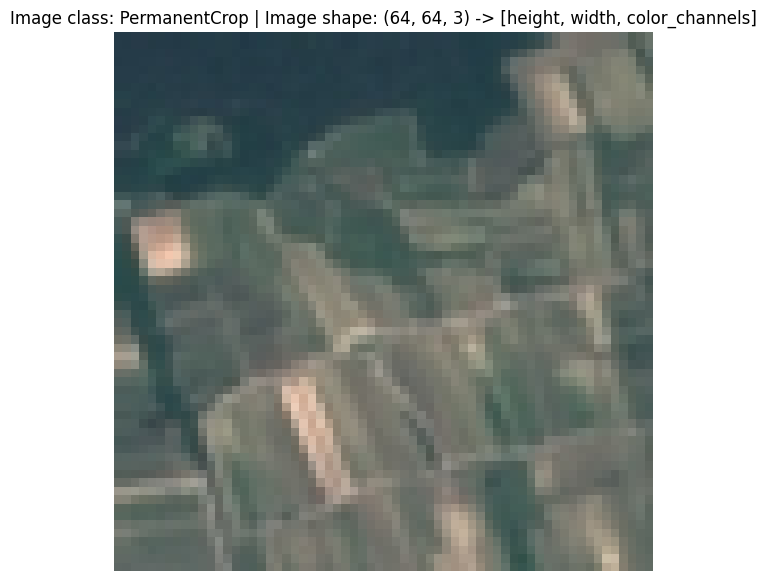

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asanyarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Tranforming

Will perform transformation expermentaly as needed

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
transform(img).dtype

torch.float32

In [ ]:
def plot_tranformed_images(image_path_list, transform, n=3, seed=None):
  """
  Will select random image and load/Tranform
  Then will plot the original vs Tranformed
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_path_list, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      # Ploting original
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")
      ax[0].axis(False)

      # Ploting tranfomed
      tranformed_image = transform(f).permute(1, 2, 0) # Change shape because of matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(tranformed_image)
      ax[1].set_title(f"Transformed\n Size: {tranformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

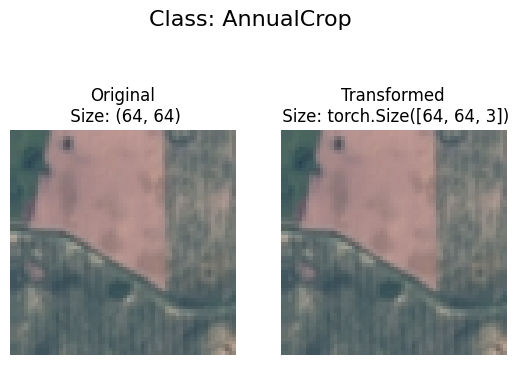

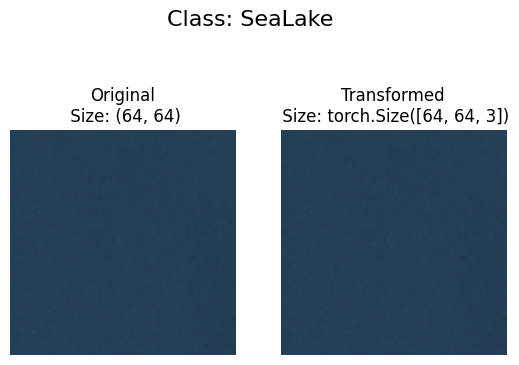

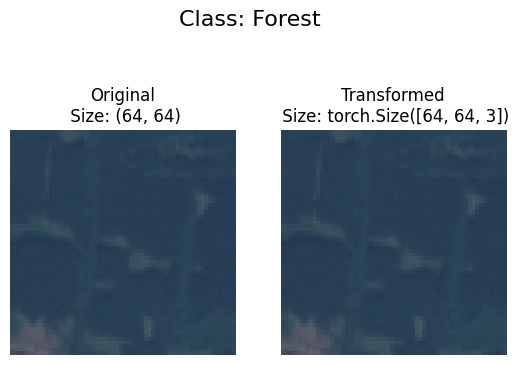

In [ ]:
plot_tranformed_images(image_path_list=image_path_list, transform=transform, n=3, seed=None)

### Other form of data Agmentation

In [ ]:
# See PyTorch Documentation, e.g. TrivialAugment


### Creating the datset

In [ ]:
full_dataset = datasets.ImageFolder(root=EuroSAT_RGB_path, transform=transform)
class_names = full_dataset.classes

train_size = int(0.8*len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
len(train_dataset), len(test_dataset)

(21600, 5400)

In [ ]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: data/EuroSAT_RGB
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
full_dataset.samples[0]

('data/EuroSAT_RGB/AnnualCrop/AnnualCrop_1.jpg', 0)

In [ ]:
# Index on the dataset to get a single image and label
img, label = full_dataset[0][0], full_dataset[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Lable datatype: {type(label)}")

Image tensor: 
 tensor([[[0.5843, 0.5843, 0.5804,  ..., 0.4000, 0.4078, 0.4039],
         [0.5843, 0.5843, 0.5804,  ..., 0.4000, 0.4078, 0.4039],
         [0.5608, 0.5569, 0.5725,  ..., 0.4000, 0.4000, 0.4039],
         ...,
         [0.5647, 0.5529, 0.5373,  ..., 0.4039, 0.3922, 0.3961],
         [0.5176, 0.5176, 0.4980,  ..., 0.4118, 0.4118, 0.4196],
         [0.4863, 0.4784, 0.4706,  ..., 0.4157, 0.4157, 0.4196]],

        [[0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
         [0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
         [0.4588, 0.4549, 0.4588,  ..., 0.3608, 0.3529, 0.3569],
         ...,
         [0.4549, 0.4588, 0.4588,  ..., 0.3647, 0.3529, 0.3569],
         [0.4314, 0.4392, 0.4314,  ..., 0.3686, 0.3647, 0.3725],
         [0.4118, 0.4157, 0.4039,  ..., 0.3725, 0.3686, 0.3725]],

        [[0.4706, 0.4706, 0.4745,  ..., 0.3922, 0.4000, 0.3961],
         [0.4706, 0.4706, 0.4745,  ..., 0.3922, 0.4000, 0.3961],
         [0.4627, 0.4588, 0.4745,  ..., 0.

Text(0.5, 1.0, 'AnnualCrop')

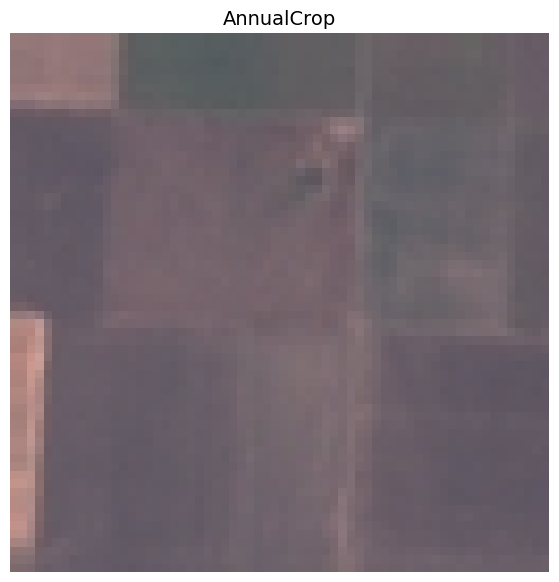

In [ ]:
# Printing Image directy from te datasete
img_permute = img.permute(1, 2, 0)

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### Displaying random image from the dataset

In [ ]:
from typing import List
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
  # Better if is less tha 10 because of display
  if n>10:
    n=10

  if seed:
    random.seed(seed)

  # 4. Getting random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # Create plot
  plt.figure(figsize=(16, 8))

  # Looping through the index and ploting them
  for i, img_sample_idx in enumerate(random_sample_idx):
    img_sample, label_sample = dataset[img_sample_idx][0], dataset[img_sample_idx][1]

    plt.subplot(1,n, i+1)
    plt.imshow(img_sample.permute(1,2,0))
    plt.axis(False)
    if classes:
      title = (f"Class: {classes[label_sample]}")
      if display_shape:
        title = title + f"\nShape: {img_sample.permute(1,2,0).shape}"
    plt.title(title)

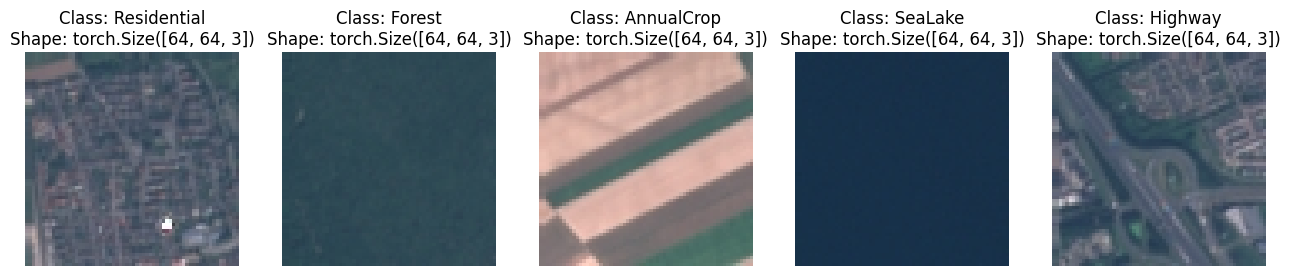

In [ ]:
display_random_images(train_dataset.dataset, n=5, classes=class_names, seed=42)

### Creatind Datalaoder

In [ ]:
# Datalaoder
BATH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_datalaoder = DataLoader(train_dataset, batch_size=BATH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
len(train_datalaoder), len(train_dataset)

(675, 21600)

In [ ]:
21600/32

675.0

In [ ]:
# Loading from the datalaoder
img, label = next(iter(train_datalaoder))
print(f"Image shape: {img.shape}-> [batch_size, color channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])-> [batch_size, color channels, height, width]
Label shape: torch.Size([32])


# Model 1

* CNN Artiteture based on CNN explainer TinyVGG

In [ ]:
class CNN_Model1(nn.Module):
  """
  Model ...
  """
  def __init__(self, input_shape: int,hidden_units: int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.pooling = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*13*13,
            out_features=output_shape
        )
    #self.pooling = nn.Sequential(nn.Flatten(), nn.LazyLinear(out_features=output_shape)) out maticlay get the in_fitures
    )

  def forward(self,x):
    #print(x.shape)
    #x=self.conv_block_1(x)
    #print(x.shape)
    #x=self.conv_block_2(x)
    #print(x.shape)
    #x=self.pooling(x)
    #print(x.shape)
    #return x
    return self.pooling(self.conv_block_2(self.conv_block_1(x)))


In [ ]:
len(class_names)

10

In [ ]:
model_1 = CNN_Model1(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1

CNN_Model1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pooling): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

## Trying foward pass on a single image to test the model

In [ ]:
image_batch, label_batch = next(iter(train_datalaoder))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_1(image_batch.to(device))

tensor([[-0.0287,  0.0619,  0.0127,  0.0260,  0.0126,  0.0417, -0.0046,  0.0507,
          0.0428, -0.0062],
        [-0.0307,  0.0614,  0.0145,  0.0239,  0.0135,  0.0408, -0.0031,  0.0513,
          0.0425, -0.0057],
        [-0.0301,  0.0620,  0.0137,  0.0248,  0.0135,  0.0414, -0.0036,  0.0511,
          0.0428, -0.0065],
        [-0.0297,  0.0617,  0.0145,  0.0243,  0.0131,  0.0410, -0.0047,  0.0509,
          0.0430, -0.0066],
        [-0.0286,  0.0618,  0.0129,  0.0261,  0.0125,  0.0417, -0.0048,  0.0505,
          0.0430, -0.0064],
        [-0.0301,  0.0614,  0.0142,  0.0248,  0.0134,  0.0400, -0.0041,  0.0513,
          0.0425, -0.0063],
        [-0.0281,  0.0615,  0.0123,  0.0266,  0.0127,  0.0420, -0.0046,  0.0506,
          0.0428, -0.0061],
        [-0.0285,  0.0620,  0.0126,  0.0259,  0.0125,  0.0414, -0.0042,  0.0504,
          0.0424, -0.0062],
        [-0.0291,  0.0618,  0.0131,  0.0276,  0.0129,  0.0418, -0.0033,  0.0518,
          0.0434, -0.0056],
        [-0.0297,  

In [ ]:
model_1(image_batch.to(device))

torch.Size([32, 3, 64, 64])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 10])


tensor([[ 2.6208e-02,  1.9570e-02,  6.0631e-02, -2.4790e-02,  1.4526e-02,
         -1.2239e-02, -2.4466e-04, -4.3226e-03, -1.9512e-02,  1.0321e-02],
        [ 2.9278e-02,  1.9023e-02,  6.1152e-02, -2.2333e-02,  1.1599e-02,
         -1.1788e-02, -1.2972e-03, -5.0179e-03, -1.8624e-02,  1.0704e-02],
        [ 2.9158e-02,  1.8453e-02,  6.2729e-02, -2.2498e-02,  1.3283e-02,
         -1.1148e-02, -8.7063e-04, -4.0230e-03, -1.9110e-02,  9.2031e-03],
        [ 3.0359e-02,  2.0386e-02,  6.0226e-02, -2.3197e-02,  1.0622e-02,
         -1.0429e-02,  4.4602e-04, -5.6673e-03, -1.8947e-02,  1.0027e-02],
        [ 2.6220e-02,  1.9640e-02,  6.0365e-02, -2.4185e-02,  1.3837e-02,
         -1.2069e-02, -1.2614e-04, -4.5609e-03, -1.9270e-02,  1.0187e-02],
        [ 2.8655e-02,  1.8979e-02,  6.1924e-02, -2.3764e-02,  1.1688e-02,
         -1.1559e-02, -8.7036e-04, -4.3172e-03, -1.7845e-02,  9.5251e-03],
        [ 2.5323e-02,  1.9772e-02,  6.0746e-02, -2.4986e-02,  1.5245e-02,
         -1.2468e-02, -2.1835e-0

In [ ]:
13*13

169

## Check the shappes of the model

Using 'torchinfo' to check the model arquiteture

In [ ]:
# Installing if not availble

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size = image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

# Training

## Training Step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # Putting the model in training mode
  model.train()

  # Setting the loss and accurecy value to accumate in each batch
  train_loss, train_acc = 0,0

  # Looping through datalaoder data batches
  for batch, (X, y) in enumerate(dataloader):
    # Sending the data to the target device
    X, y = X.to(device), y.to(device)

    # Forward pass <- logits
    y_pred = model(X)

    # Calculating the loss
    loss = loss_fn(y_pred, y)

    # Accumulating loss
    train_loss += loss.item()

    # Zero the gradient not to accumalte
    optimizer.zero_grad()

    # Back propagation - calculate the gradient
    loss.backward()

    # update the weights
    optimizer.step()

    # Calculating the accurecy logit -> pred probability -> labels
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Calculate the avarege training loss
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  # Retrun train loss and accuracy of the step to track
  return train_loss, train_acc


## Evaluation step

In [ ]:
# Creating a testing function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  # Putting the model in eval mode
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():
    #
    for batch, (X, y) in enumerate(dataloader):
      X, y =  X.to(device), y.to(device)

      test_pred_logit = model(X)

      loss = loss_fn(test_pred_logit, y)

      test_loss += loss.item()

      test_pred_labels = test_pred_logit.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

## Training Function

In [ ]:
from tqdm.auto import tqdm

def Train(model: torch.nn.Module,
          train_datalaoder: torch.utils.data.DataLoader,
          test_datalaoder: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device
          ):

  # Creating a result dictionary to track the metrics
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}

  # Training loo
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_datalaoder,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train Acc: {train_acc*100:.4f}% | Test loss:{test_loss:.4f}, Test acc: {test_acc*100:.4f}%")

    # Add parameters to the result dictionary
    results["train_loss"].append(train_loss)
    results["test_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results
  return results

## Training and evaluating

In [ ]:
# Seed maybe again---

NUM_EPOCHS = 100

# Loss function and otmizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Recorigin start time
from  timeit import default_timer as timer


start_time = timer()
model_1_results = Train(model=model_1,
                        train_datalaoder=train_datalaoder,
                        test_datalaoder=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} secods")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.2955, Train Acc: 0.1132 | Test loss:2.2956, Test acc: 0.1078
Epoch: 1 | Train loss: 2.2955, Train Acc: 0.1122 | Test loss:2.2970, Test acc: 0.1038
Epoch: 2 | Train loss: 2.2958, Train Acc: 0.1115 | Test loss:2.2950, Test acc: 0.1078
Epoch: 3 | Train loss: 2.2957, Train Acc: 0.1088 | Test loss:2.2962, Test acc: 0.1038
Epoch: 4 | Train loss: 2.2955, Train Acc: 0.1089 | Test loss:2.2950, Test acc: 0.1133
Epoch: 5 | Train loss: 2.2956, Train Acc: 0.1074 | Test loss:2.2952, Test acc: 0.1078
Epoch: 6 | Train loss: 2.2957, Train Acc: 0.1086 | Test loss:2.2958, Test acc: 0.1038
Epoch: 7 | Train loss: 2.2955, Train Acc: 0.1085 | Test loss:2.2952, Test acc: 0.1169
Epoch: 8 | Train loss: 2.2953, Train Acc: 0.1121 | Test loss:2.2963, Test acc: 0.1038
Epoch: 9 | Train loss: 2.2957, Train Acc: 0.1106 | Test loss:2.2959, Test acc: 0.1133
Epoch: 10 | Train loss: 2.2955, Train Acc: 0.1109 | Test loss:2.2956, Test acc: 0.1133
Epoch: 11 | Train loss: 2.2957, Train Acc: 0.1071 | T

KeyboardInterrupt: 

In [ ]:
len(train_datalaoder), len(test_dataloader)

(675, 169)

In [ ]:
#Traing again
# Seed maybe again---

NUM_EPOCHS = 100

# Loss function and otmizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

# Recorigin start time
from  timeit import default_timer as timer


start_time = timer()
model_1_results = Train(model=model_1,
                        train_datalaoder=train_datalaoder,
                        test_datalaoder=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} secods")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.2375, Train Acc: 15.9491% | Test loss:1.9283, Test acc: 22.8797%
Epoch: 1 | Train loss: 1.8204, Train Acc: 28.0694% | Test loss:1.7398, Test acc: 31.6075%
Epoch: 2 | Train loss: 1.7176, Train Acc: 33.6250% | Test loss:1.7884, Test acc: 28.4578%
Epoch: 3 | Train loss: 1.5728, Train Acc: 39.8796% | Test loss:1.4712, Test acc: 45.1245%
Epoch: 4 | Train loss: 1.3851, Train Acc: 48.0000% | Test loss:1.2612, Test acc: 56.3671%
Epoch: 5 | Train loss: 1.1682, Train Acc: 58.1204% | Test loss:1.0554, Test acc: 62.2719%
Epoch: 6 | Train loss: 1.0456, Train Acc: 63.0324% | Test loss:1.0001, Test acc: 64.8422%
Epoch: 7 | Train loss: 0.9532, Train Acc: 66.2685% | Test loss:0.9737, Test acc: 65.9209%
Epoch: 8 | Train loss: 0.8909, Train Acc: 68.3472% | Test loss:1.0439, Test acc: 62.1302%
Epoch: 9 | Train loss: 0.8415, Train Acc: 70.1991% | Test loss:0.8549, Test acc: 69.2369%
Epoch: 10 | Train loss: 0.7987, Train Acc: 72.0417% | Test loss:0.8618, Test acc: 69.6252%
Epoch: 11

KeyboardInterrupt: 